In [62]:
import sys
import numpy as np
from matplotlib import pyplot as plt

use_devel = True

# insert the mymujoco path for TrainDQN.py file
if use_devel:
  sys.path.insert(0, "/home/luke/mujoco-devel/rl")
else:
  sys.path.insert(0, "/home/luke/mymujoco/rl")

# create modelsaver instance
from ModelSaver import ModelSaver
directory = ""#"pb4_tests_apr23" # ""
saver = ModelSaver(f"test_data/{directory}", root="/home/luke/gripper-ros/")

from grasp_test_data import GraspTestData, set_palm_frc_threshold, set_X_frc_threshold, set_Y_frc_threshold
data_explorer = GraspTestData()

# enter folder and load test data
test_name = "sensor_scaling"
# test_name = "YCB_heuristic"
saver.enter_folder(test_name)
try:
  testdata = saver.load(id=None, filenamestarts="test_data", suffix_numbering=True)
  set_palm_frc_threshold(5.0)
  set_X_frc_threshold(10.0)
  set_Y_frc_threshold(10.0)
  data_explorer.add_palm_start_force = False
  print(data_explorer.get_test_string(data=testdata, detailed=2))

  # set_palm_frc_threshold(3.0)
  # print(data_explorer.get_test_string(data=testdata, detailed=True))
except TypeError as e:
  print("Loading test data failed, check that the test has actually saved some data")
  print("Error was:", e)

Test information

Test name: sensor_scaling
Finger width: 0.024
Finger thickness: 0.0010
heuristic test: False
Bending gauge in use: True
Palm sensor in use: True
Wrist Z sensor in use: True
Loaded group name: 11-12-23
Loaded run name: run_19-57_A120
Loaded best SR: 0.813

Results information:

num_sphere = 207
num_cuboid = 175
num_cylinder = 0
num_cube = 0
Sphere success rate: 0.8696
cylinder success rate: 0.0000
cuboid success rate: 0.9029
cube success rate: 0.0000
sphere_SR = 0.8696
cylinder_SR = 0.0000
cuboid_SR = 0.9029
cube_SR = 0.0000
avg_steps = 42.5207
avg_stable_height = 0.8848
avg_target_height = 0.8848
avg_lifted = 0.8848
avg_exceed_bending = 0.0000
avg_exceed_axial = 0.0000
avg_exceed_limits = 0.0000
avg_loop = 0.0000
avg_dropped = 0.0000
avg_out_of_bounds = 0.0000
avg_exceed_palm = 0.0000
avg_SR_per_obj = 0.8813
max_finger_frc = 4.1908N

num_palm_probes = 46 out of 338 (s.h)
avg_palm_frc_tol (5.0N) = 15.4048
avg_palm_frc_under (5.0N) = 2.4935
avg_palm_frc_saturated (5.0N)

In [63]:
# optionally also print trial information
print_trials = True
_ = data_explorer.get_test_results(data=testdata, print_trials=print_trials)

Object num = 2, num trials = 114, SH = 96
Object num = 6, num trials = 93, SH = 84
Object num = 12, num trials = 100, SH = 98
Object num = 11, num trials = 75, SH = 60


In [61]:
run_loop = True
save_original = False
save_new_trials = False

def print_trial(trial):
  try:
    print(f"Obj. num = {trial.object_num}, trial num = {trial.trial_num}, sh = {trial.stable_height}, pFTol = {trial.palm_frc_tol:.1f}, XFTol = {trial.X_frc_tol:.1f}, YFTol = {trial.Y_frc_tol:.1f}, f1_frc = {trial.finger1_force:.2f}, f2_frc = {trial.finger2_force:.2f}, f3_frc = {trial.finger3_force:.2f}, p_forc = {trial.palm_force:.2f}")
  except AttributeError:
    print(f"Obj. num = {trial.object_num}, trial num = {trial.trial_num}, sh = {trial.stable_height}, pFTol = {trial.palm_frc_tol:.1f}")

from copy import deepcopy

done = False

if run_loop and not save_new_trials:

  new_trials = []

  # edit individual trials to fix errors
  for (i, trial) in enumerate(testdata.trials):

    # if not trial.object_num in [2, 6, 7, 9, 11, 12]:
    #   if trial.trial_num < 50:
    #     continue
    # elif trial.trial_num > 50:
    #   continue

    print_trial(trial)
    new_trials.append(deepcopy(trial))

if save_original: 
  saver.save("test_data", pyobj=testdata)
if save_new_trials:
  testdata.trials = new_trials
  saver.save("test_data", pyobj=testdata)

Obj. num = 2, trial num = 1, sh = 1, pFTol = 8.3, XFTol = 0.0, YFTol = 0.0, f1_frc = 1.55, f2_frc = 1.32, f3_frc = 1.63, p_forc = 3.29
Obj. num = 2, trial num = 2, sh = 1, pFTol = 11.8, XFTol = 0.0, YFTol = 0.0, f1_frc = 1.00, f2_frc = 1.18, f3_frc = 1.32, p_forc = 3.23
Obj. num = 2, trial num = 3, sh = 1, pFTol = 21.1, XFTol = 0.0, YFTol = 0.0, f1_frc = 0.92, f2_frc = 1.20, f3_frc = 0.98, p_forc = 1.43
Obj. num = 2, trial num = 4, sh = 1, pFTol = 15.9, XFTol = 0.0, YFTol = 0.0, f1_frc = 1.67, f2_frc = 1.24, f3_frc = 1.85, p_forc = 2.69
Obj. num = 2, trial num = 5, sh = 1, pFTol = 15.3, XFTol = 0.0, YFTol = 0.0, f1_frc = 1.43, f2_frc = 0.99, f3_frc = 1.62, p_forc = 2.54
Obj. num = 2, trial num = 6, sh = 0, pFTol = 0.0, XFTol = 0.0, YFTol = 0.0, f1_frc = 1.32, f2_frc = 0.99, f3_frc = 1.86, p_forc = 2.13
Obj. num = 2, trial num = 7, sh = 0, pFTol = 0.0, XFTol = 0.0, YFTol = 0.0, f1_frc = 0.00, f2_frc = 0.00, f3_frc = 0.00, p_forc = 0.00
Obj. num = 2, trial num = 8, sh = 0, pFTol = 0.0, X

In [4]:
def get_test_data(tests, Xt=10.0, Yt=10.0, Zt=10.0, add_palm_frc=False, printout=False):

  saver.log_level = 0

  combined_trials = []
  if not isinstance(tests, list):
    tests = [tests]
  for name in tests:
    saver.enter_folder(name)
    testdata = saver.load(id=None, filenamestarts="test_data", suffix_numbering=True)
    for t in testdata.trials:
      combined_trials.append(t)

  testdata.trials = combined_trials
  set_palm_frc_threshold(Zt)
  set_X_frc_threshold(Xt)
  set_Y_frc_threshold(Yt)
  data_explorer.add_palm_start_force = add_palm_frc

  if printout:
    print(data_explorer.get_test_string(data=testdata, detailed=True))

  return data_explorer.get_test_results(data=testdata)

# enter folder and load test data
test_names = ["pb1_E2_S3_real", "pb1_E2_S3_real_disturb"]
test_names = ["pb1_E2_S3_YCB", "palm_E2_75_YCB_e2"]
test_names = ["real_heuristic", "real_heuristic_disturb"]

In [6]:
def combine(item1, item2):
  out = []
  if isinstance(item1, list):
    out = item1
  else: out.append(item1)
  if isinstance(item2, list):
    out += item2
  else: out.append(item2)
  return out

real_tests = [
  ["pb1_E2_S3_real", "pb1_E2_S3_real_disturb_extended"],
  ["real_heuristic", "real_heuristic_disturb_extended"],
  ["shaped_MAT_real", "shaped_MAT_real_disturb"], 
  ["MAT_liftonly_real", "MAT_liftonly_real_disturb"],
]
real_disturb_tests = [
  "pb1_E2_S3_real_disturb_extended",
  "real_heuristic_disturb",
  ["shaped_MAT_real_disturb", "shaped_MAT_real"],
  ["MAT_liftonly_real_disturb", "MAT_liftonly_real"],
]
ycb_tests = [
  ["pb1_E2_S3_YCB", "pb1_E2_S3_YCB_disturb"],
  ["YCB_heuristic", "YCB_heuristic_disturb"],
  ["shaped_MAT_ycb", "shaped_MAT_ycb_disturb"],
  ["MAT_liftonly_ycb", "MAT_liftonly_ycb_disturb"],
]
ycb_disturb_tests = [
  "pb1_E2_S3_YCB_disturb", # palm_E2_75_YCB_e2, this test should be repeated, data is incomplete
  "YCB_heuristic_disturb",
  ["shaped_MAT_ycb_disturb", "shaped_MAT_ycb"],
  ["MAT_liftonly_ycb_disturb", "MAT_liftonly_ycb"],
]
controllers = ["PPO (ours)", "Heuristic", "MAT + ours", "MAT"]

headers = f"{'Controller':<12} | {'Objects':<8} | {'Finger / N':<12} | {'Palm / N':<12} | {'Steps':<8} | {'X tol / N':<9} | {'Y tol / N':<9} | {'Z tol / N':<9} | {'SR %':<8} | {'Stable 5N %':<12} | {'Trials':<6}"
rows = "{:<12} | {:<8} | {:<12.3f} | {:<12.3f} | {:<8.2f} | {:<9.3f} | {:<9.3f} | {:<9.3f} | {:<8.2f} | {:<12.2f} | {:<6}"

# add in 95 confidence interval to success rate and stable 5N rate
add_stat_sig = True
if add_stat_sig:
  headers += f" | {'SR 95CI%':<8} | {'+':<5} | {'-':<5} | {'S5N 95CI%':<9} | {'+':<5} | {'-':<5}"
  rows += " | {:<8.2f} | {:<5.2f} | {:<5.2f} | {:<9.2f} | {:<5.2f} | {:<5.2f}"

print(headers)

real_objects = []
ycb_objects = []

print_alternating = False
print_singles = True
print_both = True

if print_singles:
  for i in range(4 * (1 + (not print_alternating))):
    ind = i
    if print_alternating or i >= 4:
      if not print_alternating: ind -= 4
      ycb_disturb = get_test_data(ycb_disturb_tests[ind], Zt=10.0)
      ycb_main = get_test_data(ycb_tests[ind], Zt=10.0)
      ycb_5N = get_test_data(ycb_tests[ind], Zt=5.0)
      ycb_format = [controllers[ind], "YCB", ycb_main.avg_f_frc, ycb_main.avg_p_frc, ycb_main.avg_steps,
                    ycb_disturb.avg_X_frc_saturated, ycb_disturb.avg_Y_frc_saturated, 
                    ycb_disturb.avg_palm_frc_saturated,
                    ycb_main.avg_SR_per_obj * 100, ycb_5N.rate_palm_frc_tol * 100,
                    ycb_main.num_trials]
      if add_stat_sig:
        ycb_format += [ycb_main.CI_95 * 100, ycb_main.CI_95_max * 100, ycb_main.CI_95_min * 100, 
                      ycb_5N.CI_95_s5N * 100, ycb_5N.CI_95_s5N_max * 100, ycb_5N.CI_95_s5N_min * 100]
      print(rows.format(*ycb_format))
      ycb_objects.append(list(ycb_main.object_sr))
    if print_alternating or i < 4:
      real_disturb = get_test_data(real_disturb_tests[ind], Zt=10.0)
      real_main = get_test_data(real_tests[ind], Zt=10.0)
      real_5N = get_test_data(real_tests[ind], Zt=5.0)
      real_format = [controllers[ind], "Real", real_main.avg_f_frc, real_main.avg_p_frc, real_main.avg_steps,
                    real_disturb.avg_X_frc_saturated, real_disturb.avg_Y_frc_saturated, 
                    real_disturb.avg_palm_frc_saturated,
                    real_main.avg_SR_per_obj * 100, real_5N.rate_palm_frc_tol * 100,
                    real_main.num_trials]
      if add_stat_sig:
        real_format += [real_main.CI_95 * 100, real_main.CI_95_max * 100, real_main.CI_95_min * 100, 
                        real_5N.CI_95_s5N * 100, real_5N.CI_95_s5N_max * 100, real_5N.CI_95_s5N_min * 100]
      print(rows.format(*real_format))
      real_objects.append(list(real_main.object_sr))
    
if print_both:
  for ind in range(4):
    both_disturb = get_test_data(combine(ycb_disturb_tests[ind], real_disturb_tests[ind]), Zt=10.0)
    both_main = get_test_data(combine(ycb_tests[ind], real_tests[ind]), Zt=10.0)
    both_5N = get_test_data(combine(ycb_tests[ind], real_tests[ind]), Zt=5.0)
    both_format = [controllers[ind], "YCB+real", both_main.avg_f_frc, both_main.avg_p_frc, both_main.avg_steps,
                   both_disturb.avg_X_frc_saturated, both_disturb.avg_Y_frc_saturated, 
                   both_disturb.avg_palm_frc_saturated,
                   both_main.avg_SR_per_obj * 100, both_5N.rate_palm_frc_tol * 100,
                   both_main.num_trials]
    if add_stat_sig:
      both_format += [both_main.CI_95 * 100, both_main.CI_95_max * 100, both_main.CI_95_min * 100, 
                      both_5N.CI_95_s5N * 100, both_5N.CI_95_s5N_max * 100, both_5N.CI_95_s5N_min * 100]
    print(rows.format(*both_format))

Controller   | Objects  | Finger / N   | Palm / N     | Steps    | X tol / N | Y tol / N | Z tol / N | SR %     | Stable 5N %  | Trials | SR 95CI% | +     | -     | S5N 95CI% | +     | -    
PPO (ours)   | Real     | 0.000        | 0.000        | 40.37    | 4.470     | 5.285     | 7.556     | 95.83    | 79.67        | 240    | 1.45     | 96.92 | 94.38 | 2.65      | 82.08 | 77.02
Heuristic    | Real     | 0.000        | 0.000        | 85.77    | 4.551     | 4.538     | 5.914     | 77.55    | 52.74        | 243    | 2.71     | 80.05 | 74.84 | 3.13      | 55.85 | 49.61
MAT + ours   | Real     | 1.586        | 1.825        | 40.36    | 3.910     | 4.628     | 5.877     | 78.20    | 62.24        | 177    | 3.17     | 81.08 | 75.03 | 3.61      | 65.72 | 58.64
MAT          | Real     | 1.536        | 0.035        | 16.66    | 3.141     | 2.592     | 5.573     | 73.17    | 53.33        | 159    | 3.56     | 76.46 | 69.62 | 3.87      | 57.16 | 49.47
PPO (ours)   | YCB      | 0.000        | 0.00

In [7]:
print(real_objects)

[[1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.9, 1.0, 0.9, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.8, 0.9, 1.0, 0.0], [0.7, 0.9, 0.5454545454545454, 1.0, 0.7, 1.0, 1.0, 0.8, 0.9, 1.0, 0.7, 0.6, 0.6, 1.0, 0.2, 1.0, 0.9, 0.7, 0.0, 0.6666666666666666, 0.9, 0.8, 1.0, 1.0, 0.0], [0.5, 1.0, 0.7777777777777778, 0.7142857142857143, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 0.0, 0.8571428571428571, 0.25, 1.0, 0.5555555555555556, 1.0, 0.8571428571428571, 0.625, 0.4, 0.8571428571428571, 1.0, 0.5, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.7142857142857143, 0.8571428571428571, 1.0, 0.8571428571428571, 0.625, 0.2, 1.0, 0.2, 0.16666666666666666, 1.0, 0.375, 0.6666666666666666, 0.4, 1.0, 0.4, 0.6, 1.0, 0.0]]


In [ ]:
# find finger forces at the end of trials, old method, not needed now
avg_finger_force = 0
avg_palm_force = 0
avg_steps = 0
count = 0
num_sh = 0

palm_data_entry = 6 # 6 for old tests, 3 for new tests

get_force_data = True
if get_force_data:

  # loop over trials to 
  for (i, trial) in enumerate(testdata.trials):

    if trial.stable_height:

      num_sh += 1

      try:
        finger_force = (1/3.0) * (trial.steps[-1].SI_state[0] + trial.steps[-1].SI_state[1] + trial.steps[-1].SI_state[2])
      except:
        # print_trial(trial)
        continue
      avg_finger_force += finger_force
      palm_force = (1/3.0) * (trial.steps[-1].SI_state[palm_data_entry] + trial.steps[-2].SI_state[palm_data_entry] + trial.steps[-3].SI_state[palm_data_entry])
      p1 = trial.steps[-1].SI_state[palm_data_entry]
      p2 = trial.steps[-2].SI_state[palm_data_entry]
      p3 = trial.steps[-3].SI_state[palm_data_entry]
      p4 = trial.steps[-4].SI_state[palm_data_entry]
      p5 = trial.steps[-5].SI_state[palm_data_entry]
      if p1 > 1.0 and p1 < 4.0: palm_force = p1
      elif p2 > 1.0 and p2 < 4.0: palm_force = p2
      elif p3 > 1.0 and p3 < 4.0: palm_force = p3
      elif 0.5 * (p1 + p2) > 1.0 and 0.5 * (p1 + p2) < 4.0: palm_force = 0.5 * (p1 + p2)
      elif 0.5 * (p1 + p3) > 1.0 and 0.5 * (p1 + p3) < 4.0: palm_force = 0.5 * (p1 + p3)
      elif 0.5 * (p3 + p2) > 1.0 and 0.5 * (p3 + p2) < 4.0: palm_force = 0.5 * (p3 + p2)
      else: 
        count += 1
        palm_force = 4.0
      avg_palm_force += palm_force

      avg_steps += len(trial.steps)

      print(trial.steps[-1].SI_state)

  print("Test name", test_name)
  print("Average finger force", avg_finger_force / num_sh)
  print("Average palm force", avg_palm_force / num_sh)
  print("Average steps", avg_steps / num_sh)
  print("num stable height was", num_sh)
  print("count was", count)


[1.3895500898361206, 1.2339588403701782, 1.175703525543213, 0.0, 0.0, 0.0, 0.1898709535598755, 0.0, 0.0, -3.0132923126220703, 0.06917500495910645, 0.05855000391602516, 0.13117371499538422, -0.022555431351065636]
[-0.11981497704982758, 0.980143129825592, 1.1420882940292358, 0.0, 0.0, 0.0, 0.20590201020240784, 0.0, 0.0, -4.971390724182129, 0.06591500341892242, 0.057705000042915344, 0.1260591745376587, -0.026561420410871506]
[1.4816181659698486, 1.1925311088562012, 2.0735652446746826, 0.0, 0.0, 0.0, 11.332111358642578, 0.0, 0.0, -2.0618338584899902, 0.07158000022172928, 0.058435000479221344, 0.13534338772296906, 0.0]
[1.4492286443710327, 0.49513116478919983, 1.4142482280731201, 0.0, 0.0, 0.0, 0.11569153517484665, 0.0, 0.0, 0.41595232486724854, 0.06928999722003937, 0.05915500223636627, 0.12657123804092407, -0.029999999329447746]
[1.0777572393417358, 0.6000546216964722, 2.6647911071777344, 0.0, 0.0, 0.0, 1.145492672920227, 0.0, 0.0, -3.4171218872070312, 0.07288999855518341, 0.06477000564336

In [ ]:
avg = 0
min = 100000
max = 0

for i in range(len(testdata.trials)):
  avg += len(testdata.trials[i].steps)
  if len(testdata.trials[i].steps) < min: min = len(testdata.trials[i].steps)
  if len(testdata.trials[i].steps) > max: max = len(testdata.trials[i].steps)
avg /= len(testdata.trials)

print(f"The number of trials was {len(testdata.trials)}. The average trial length was {avg:.1f} steps. The minimum steps was {min}, maximum was {max}.")

The number of trials was 57. The average trial length was 42.7 steps. The minimum steps was 31, maximum was 117.


In [ ]:
# explore raw network inputs
trial = 32
start_step = 0
num_steps_to_print = "all" # use "all" for every step

# do we load a model? Try to avoid reload
# force_reload = True
# if "model" not in globals() or force_reload:
from TrainingManager import TrainingManager
tm = TrainingManager(log_level=0)
tm.trainer = tm.make_trainer()
tm.trainer.env = tm.make_env(load=False)
tm.trainer.modelsaver = saver
tm.trainer.load(test_name)
model = tm.trainer

# print an observation table
print("\nPreparing to print a table of observations:\n")

# get observation info
info = model.env.mj.debug_observation(testdata.trials[0].steps[0].state_vector, False)
if info.startswith("INVALID"): print(info)

# parse info to get sensor names and n samples (last element is observation length)
sensor_names = [x.split(" = ")[0] for x in info.split(" | ")][:-1]
sensor_nums = [int(x.split(" = ")[1]) for x in info.split(" | ")][:-1]

# create the row master for the table
sepbig = " || " # seperate sensors
sep = " "     # seperate individual values

# input the sensor value format
sub_head = "{{{0}:{1}}}"
sf = ".3f"
sub_val = sub_head.format(0, sf)

# now create the rows for the table
sub_heading_fields = []
main_headings = sepbig
sub_headings = sepbig
row_string = sepbig
main_idx = 0
sub_idx = 0
for n in sensor_nums:
  sub_width = len(sub_val.format(-1.0) + sep)
  width = n * sub_width - len(sep)
  this_sub = ""
  for i in range(n):
    if i != n - 1:
      this_sub += sub_head.format(sub_idx + i, f"^{sub_width - len(sep)}") + sep
      row_string += sub_head.format(sub_idx + i, f">{sub_width - len(sep)}{sf}") + sep
    else:
      this_sub += sub_head.format(sub_idx + i, f"^{sub_width - len(sep)}") + sepbig
      row_string += sub_head.format(sub_idx + i, f">{sub_width - len(sep)}{sf}") + sepbig
    x = n // 2
    xi = i // 2
    if i % 2 == 0: # even
      sub_heading_fields.append(f"X{x-xi}")
    else: sub_heading_fields.append(f"Y{x-xi}-{x-xi-1}")
  main_idx += 1
  sub_idx += n
  main_headings += f"{{{main_idx}:^{width}}}" + sepbig
  sub_headings += this_sub

# print(main_headings)
# print(sub_headings)
# print(row_string)

row_prefix = sepbig + "{0:>4}"

# now input the data
sensor_names.insert(0, "dummy") # not sure why I need this
main_heading_row = main_headings.format(*sensor_names)
print(row_prefix.format("Step") + main_heading_row)

sub_heading_row = sub_headings.format(*sub_heading_fields)
print(row_prefix.format("") + sub_heading_row)

# check if the number of steps to print is too high
if num_steps_to_print == "all":
  num_steps_to_print = 1000
if start_step + num_steps_to_print > len(testdata.trials[trial].steps):
  num_steps_to_print = len(testdata.trials[trial].steps) - start_step

for i in range(start_step, start_step + num_steps_to_print):

  this_row = row_string.format(*testdata.trials[trial].steps[i].state_vector)
  print(row_prefix.format(i) + this_row)

# for i in range(start_step, start_step + num_steps_to_print):
#   print(testdata.trials[trial].steps[i].SI_state[3]) # raw data

RuntimeError: Unable to cast Python instance of type <class 'mjpy.bind.Sensor'> to C++ type 'bool'

There are 53 images


TypeError: '<' not supported between instances of 'NoneType' and 'int'

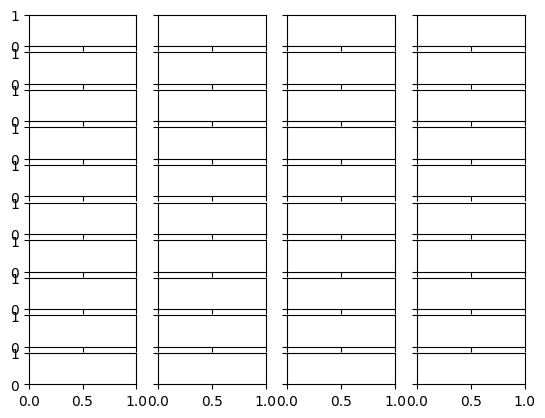

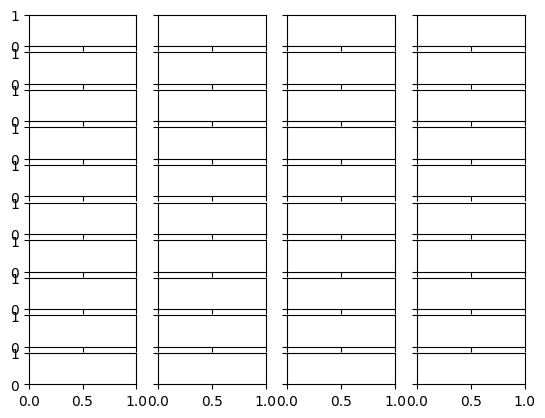

In [ ]:
# prepare to load image data
new_test = False
if new_test:
  test_name = "op-curriculum-test"
  saver.enter_folder(test_name)

new_trial = True
if new_trial:
  trial = 73

# extract the image data
imagedata = saver.load(id=trial, filenamestarts="trial_image_batch")
image_list = imagedata.trials[0].images
print("There are", len(image_list), "images")

# how many images would we like to plot
rows = 10
cols = 4

num_images = rows * cols
if num_images > len(image_list): num_images = len(image_list)

fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True)
fig2, axs2 = plt.subplots(rows, cols, sharex=True, sharey=True)

# saturate any values above this (ignore outliers)
depth_max = 5000

# find minimum of minima & maximum of depth data
dmin = 1e10
dmax = -1e10
for i in range(len(image_list)):
  this_min = np.min(image_list[i].depth[image_list[i].depth < depth_max])
  this_max = np.max(image_list[i].depth[image_list[i].depth < depth_max])
  if this_min < dmin: dmin = this_min
  if this_max > dmax: dmax = this_max

for j in range(num_images):
  ix = j // cols
  iy = j % cols
  im1 = axs[ix][iy].imshow(image_list[j].rgb, aspect="auto")
  im2 = axs2[ix][iy].imshow(image_list[j].depth, vmin=dmin, vmax=dmax, aspect='auto', cmap="viridis")

fig2.subplots_adjust(right=0.8)
cbar_ax = fig2.add_axes([0.85, 0.15, 0.05, 0.7])
fig2.colorbar(im2, cax=cbar_ax)

fig.suptitle("RGB images")
fig2.suptitle("Depth images")

fig.set_size_inches((cols * 3, rows * 2))
fig2.set_size_inches((cols * 3, rows * 2))

fig.savefig("/home/luke/gripper-ros/test_data/demo_rgb_data.png")
fig2.savefig("/home/luke/gripper-ros/test_data/demo_depth_data.png")
plt.show()


In [ ]:
im2.get_size()

image_list[-1].rgb.shape

(360, 640, 3)